## Chapter 20 - Metric Predicted Variable with Multiple Nominal Predictors

- [20.2 - Hierarchical Bayesian Approach](#20.2---Hierarchical-Bayesian-Approach)
 - [20.2.3 - Main effect contrasts](#20.2.3---Main-effect-contrasts)
- [20.4 - Heterogenous Variances and Robustness against Outliers](#20.4---Heterogenous-Variances-and-Robustness-against-Outliers)
- 20.5 - Within-Subject Designs
 - [20.5.2 Split-plot design](#20.5.2---Split-plot-design)
 - Added by Or: Randomized Control Trial, taken from Kruschke et al 2017.

In [18]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from scipy.stats import norm
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
def plot_mustache(var, sd, j, width=.75, ax=None):
    for i in np.arange(0, len(var), int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        ax.plot(-xrange_scaled+j, yrange, color=color, alpha=.6, zorder=99)

### 20.2 - Hierarchical Bayesian Approach

In [4]:
df = pd.read_csv('data/Salary.csv', usecols=[0,3,5], dtype={'Org': 'category', 'Pos': 'category'})

# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Org     1080 non-null   category
 1   Pos     1080 non-null   category
 2   Salary  1080 non-null   int64   
dtypes: category(2), int64(1)
memory usage: 13.4 KB


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  after removing the cwd from sys.path.
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [5]:
df.groupby('Pos').apply(lambda x: x.head(2))

Org      Pos  Salary
Pos                               
Assis   4    LGED    Assis   63796
        6    INFO    Assis   98814
Assoc   0      PL    Assoc   72395
        1    MUTH    Assoc   61017
Full    7    CRIN     Full  107745
        9     PSY     Full  173302
Endow   5    MGMT    Endow  219600
        8    CRIN    Endow  114275
Disting 29   SPEA  Disting  285000
        128  MUHI  Disting  114189

#### Model (Kruschke, 2015)

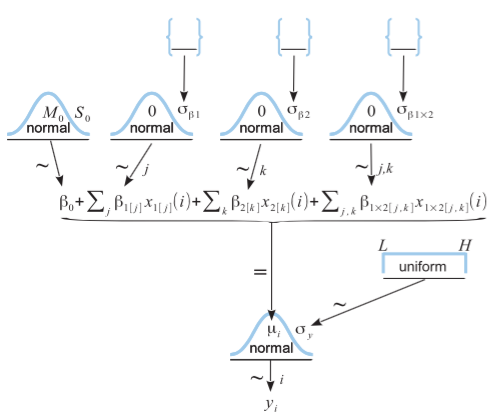

In [6]:
Image('images/fig20_2.png')

Reparameterization of hierarchical models generally results in much more efficient and faster sampling.  
See http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/ and  
http://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html

In [6]:
y = df.Salary
yMean = y.mean()
ySD = y.std()

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD)

with pm.Model() as model1:
    
    #a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0, sd=1)
    a0 = pm.Deterministic('a0', yMean + ySD*5*a0_tilde)
        
    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    #a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a1_tilde = pm.Normal('a1_tilde', mu=0, sd=1, shape=Nx1Lvl)
    a1 = pm.Deterministic('a1', 0.0 + a1SD*a1_tilde)
    
    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    #a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    a2_tilde = pm.Normal('a2_tilde', mu=0, sd=1, shape=Nx2Lvl)
    a2 = pm.Deterministic('a2', 0.0 + a2SD*a2_tilde)
        
    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    #a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
    a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sd=1, shape=(Nx1Lvl, Nx2Lvl))
    a1a2 = pm.Deterministic('a1a2', 0.0 + a1a2SD*a1a2_tilde)
        
    mu = a0 + a1[x1] + a2[x2] +a1a2[x1, x2]
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    
    like = pm.Normal('like', mu, sd=ySigma, observed=y)    

In [8]:
n_samples = 10000
with model1:
    trace1 = pm.sample(n_samples, target_accept=.95)    

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySigma, a1a2_tilde, a1a2SD, a2_tilde, a2SD, a1_tilde, a1SD, a0_tilde]


ValueError: Not enough samples to build a trace.

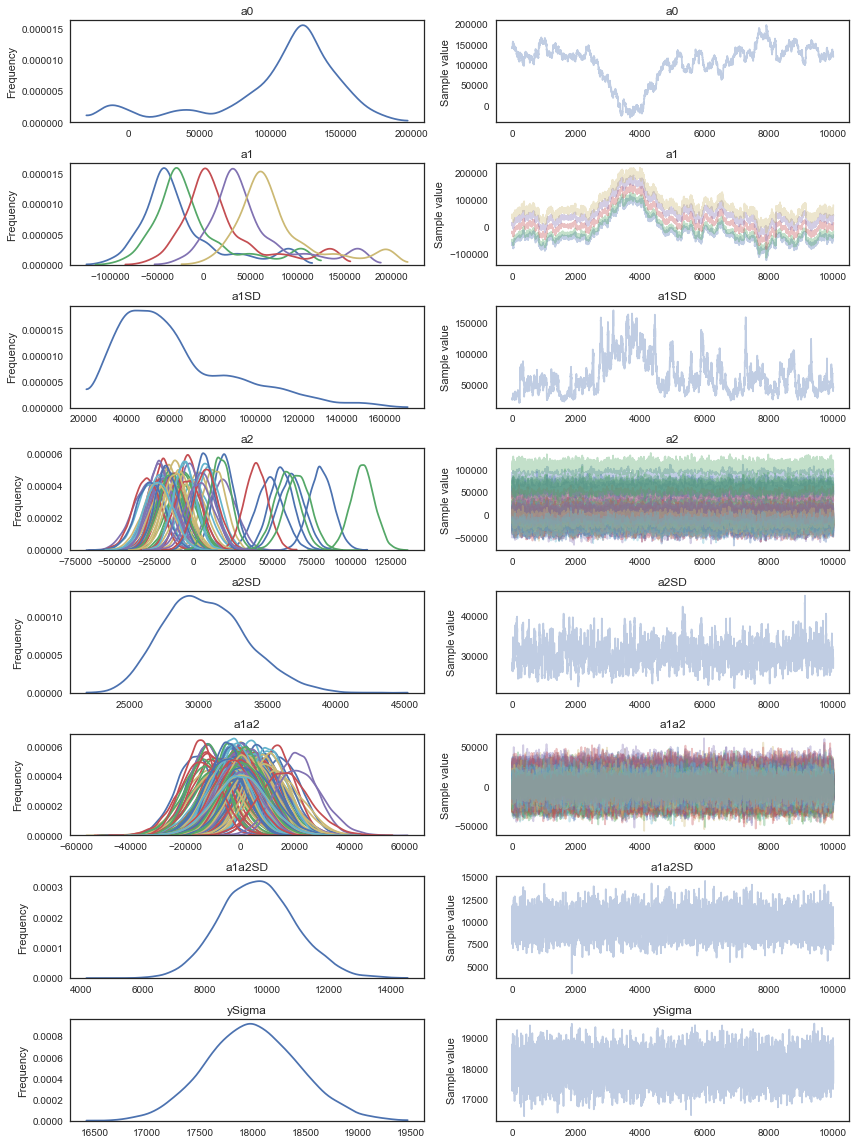

In [86]:
pm.traceplot(trace1, varnames=['a0', 'a1', 'a1SD', 'a2', 'a2SD', 'a1a2', 'a1a2SD', 'ySigma']);

In [122]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, len(trace1)))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace1['a0'] +
                     trace1['a1'][:,j1] +
                     trace1['a2'][:,j2] +
                     trace1['a1a2'][:,j1,j2])

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

# Below are the values corresponding to the first column of table 20.2
print('b0: {}'.format(np.round(np.mean(b0))))
print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
print('b2: {}'.format(np.round(np.mean(b2, axis=1))[[20,48,12,7]]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,12]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,12]))
print('ySigma: {}'.format(np.round(np.mean(trace1['ySigma']))))

b0: 127106.0
b1: [-46398. -33094.  -3145.  26997.  55640.]
b2: [ -19362.    6687.   19206.  109196.]
b1b2: -3264.0
b1b2: -15098.0
b1b2: -12821.0
b1b2: 12978.0
ySigma: 17990.0


#### Figure 20.3

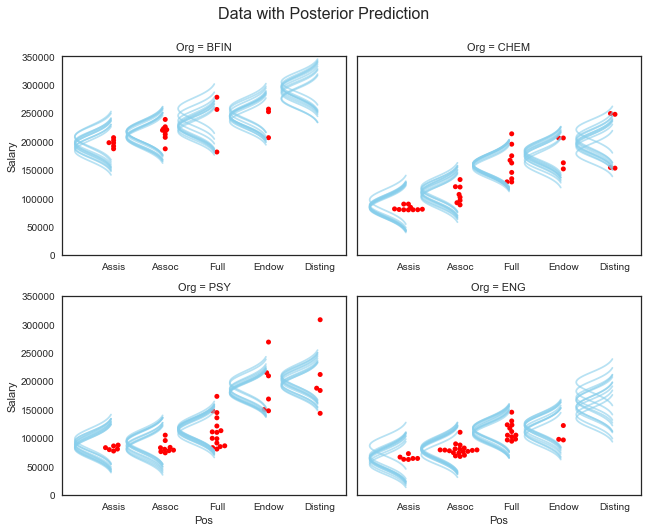

In [88]:
burnin = 200
scale = trace1['ySigma']

# Figure 20.8 in the book shows the Salary data for four of the sixty departments.
# Let's create the subset for plotting. 
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]

fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org,
                   col_wrap=2, size=3.5, aspect=1.3, despine=False, sharex=False) 
fg.map(sns.swarmplot, 'Pos', 'Salary', data=subset_df, color='r')
fg.fig.suptitle('Data with Posterior Prediction', y=1.05, fontsize=16)
for ax in fg.axes:
    ax.set_xlim(xmin=-1)
    ax.set_ylim((0,350000))
    
for i, org_idx in enumerate([7,12,48,20]):
    for pos_idx in np.arange(5):
        plot_mustache(b0[burnin:]+
                      b1[pos_idx, burnin:]+
                      b2[org_idx,burnin:]+
                      b1b2[pos_idx,org_idx,burnin:], scale[burnin:], pos_idx, ax=fg.axes.flatten()[i])

### 20.2.3 - Main effect contrasts
#### Figure 20.4

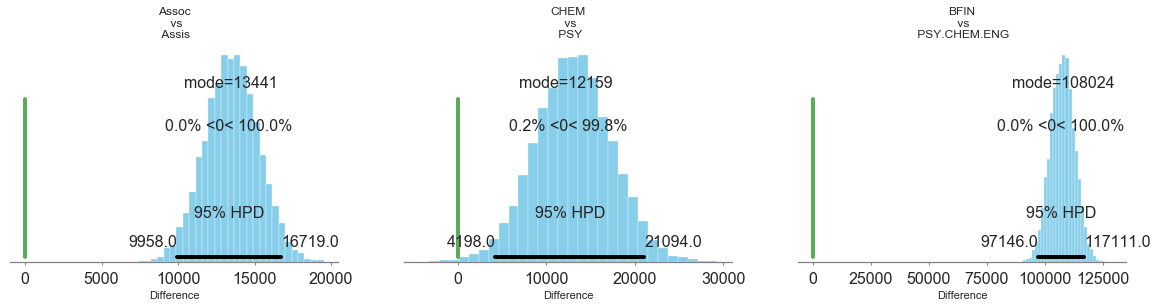

In [89]:
contrasts = [b1[1,:]-b1[0,:],
             b2[12,:]-b2[48,:],
             b2[7,:]-np.mean([b2[48,:], b2[12,:], b2[20,:]], axis=0)]

titles = ['Assoc\n vs\n Assis',
          'CHEM\n vs\n PSY',
          'BFIN\n vs\n PSY.CHEM.ENG']        

fig, axes = plt.subplots(1,3, figsize=(20,4))

for c, t, ax in zip(contrasts, titles, axes):
    pm.plot_posterior(c, point_estimate='mode', round_to=0, ref_val=0, color=color, ax=ax)
    ax.set_title(t)
    ax.set_xlabel('Difference')

### 20.2.4 - Interaction contrasts and simple effects

#### Figure 20.5

In [17]:
# The posteriors for the main contrasts can be calculated directly from the parameters.
# The posterior for the interaction contrast (rightmost plot) however, is calculated as follows.

# Full vs Assis
P = np.zeros(Nx1Lvl, dtype=np.int)
P[df.Pos.cat.categories == 'Full'] = 1
P[df.Pos.cat.categories == 'Assis'] = -1

# CHEM vs PSY
O = np.zeros(Nx2Lvl, dtype=np.int)
O[df.Org.cat.categories == 'CHEM'] = 1
O[df.Org.cat.categories == 'PSY'] = -1

# The signs in the above vectors can be flipped, the end result (posterior) will be the same.
# Using the outer product of these two vectors, we get the matrix we need to multiply
# with the trace values of b1b2.
ic_factors = np.outer(P,O)
pd.DataFrame(ic_factors, index=df.Pos.cat.categories, columns=df.Org.cat.categories)

,ACTG,AFRO,AMST,ANTH,APHS,AST,BEPP,BFIN,BI,BLAN,...,RPAD,SLIS,SLS,SOC,SPAN,SPEA,SPHS,STAT,TELC,THTR
Assis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Assoc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Full,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Endow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Disting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


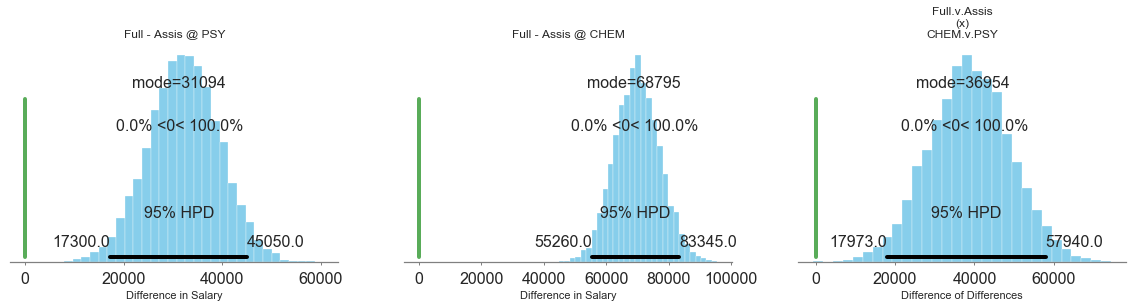

In [101]:
contrasts = [m[(df.Pos.cat.categories == 'Full').argmax(),
               (df.Org.cat.categories == 'PSY').argmax(),:] - 
             m[(df.Pos.cat.categories == 'Assis').argmax(),
               (df.Org.cat.categories == 'PSY').argmax(),:],
             
             m[(df.Pos.cat.categories == 'Full').argmax(),
               (df.Org.cat.categories == 'CHEM').argmax(),:] - 
             m[(df.Pos.cat.categories == 'Assis').argmax(),
               (df.Org.cat.categories == 'CHEM').argmax(),:],
             np.tensordot(ic_factors, b1b2)]

titles = ['Full - Assis @ PSY',
          'Full - Assis @ CHEM',
          'Full.v.Assis\n(x)\nCHEM.v.PSY']

xlabels = ['Difference in Salary']*2 + ['Difference of Differences']

fig, axes = plt.subplots(1,3, figsize=(20,4))

for c, t, l, ax in zip(contrasts, titles, xlabels, axes):
    pm.plot_posterior(c, point_estimate='mode', round_to=0, ref_val=0, color=color, ax=ax)
    ax.set_title(t)
    ax.set_xlabel(l)

### 20.4 - Heterogenous Variances and Robustness against Outliers

#### Model (Kruschke, 2015)

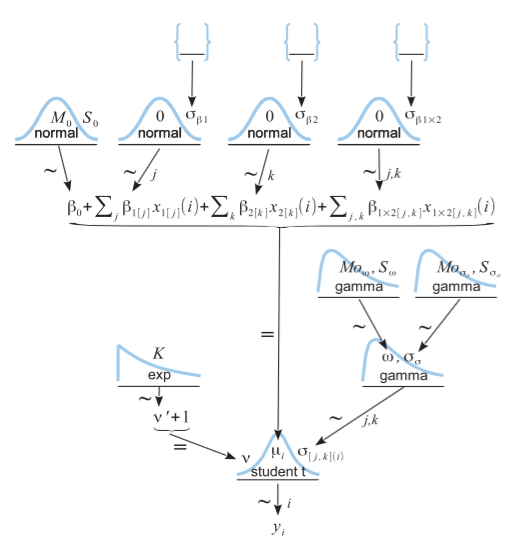

In [8]:
Image('images/fig20_7.png')

In [19]:
y = df.Salary

yMean = y.mean()
ySD = y.std()
agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD )

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

cellSDs = df.groupby(['Org','Pos']).std().dropna()
medianCellSD = cellSDs.median().squeeze()
sdCellSD = cellSDs.std().squeeze()
sgammaShRa = gammaShRaFromModeSD(medianCellSD, 2*sdCellSD)

with pm.Model() as model2:
        
    #a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0, sd=1)
    a0 = pm.Deterministic('a0', yMean + ySD*5*a0_tilde)
        
    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    #a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a1_tilde = pm.Normal('a1_tilde', mu=0, sd=1, shape=Nx1Lvl)
    a1 = pm.Deterministic('a1', 0.0 + a1SD*a1_tilde)
    
    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    #a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    a2_tilde = pm.Normal('a2_tilde', mu=0, sd=1, shape=Nx2Lvl)
    a2 = pm.Deterministic('a2', 0.0 + a2SD*a2_tilde)
        
    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    #a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
    a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sd=1, shape=(Nx1Lvl, Nx2Lvl))
    a1a2 = pm.Deterministic('a1a2', 0.0 + a1a2SD*a1a2_tilde)
    
    mu = a0 + a1[x1] + a2[x2] + a1a2[x1, x2]
             
    sigmaMode = pm.Gamma('sigmaMode', sgammaShRa[0], sgammaShRa[1]) 
    sigmaSD = pm.Gamma('sigmaSD', sgammaShRa[0], sgammaShRa[1]) 
    sigmaRa = pm.Deterministic('sigmaRa', (sigmaMode + tt.sqrt(sigmaMode**2 + 4*sigmaSD**2)) / (2*sigmaSD**2))
    sigmaSh = pm.Deterministic('sigmaSh', (sigmaMode * sigmaRa))
    sigma = pm.Gamma('sigma', sigmaSh, sigmaRa, shape=(Nx1Lvl, Nx2Lvl))
    ySigma = pm.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
        
    nu = pm.Exponential('nu', 1/30.)
        
    like = pm.StudentT('like', nu, mu, lam=1/(ySigma[x1, x2])**2, observed=y)    

In [21]:
n_samples = 1000
with model2:
    trace2 = pm.sample(n_samples, nuts_kwargs={'target_accept':.95})

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 12,097:  23%|██▎       | 45384/200000 [00:32<01:49, 1406.27it/s]
Convergence archived at 45500
Interrupted at 45,500 [22%]: Average Loss = 13,081
100%|██████████| 1500/1500 [22:06<00:00,  1.15it/s]/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



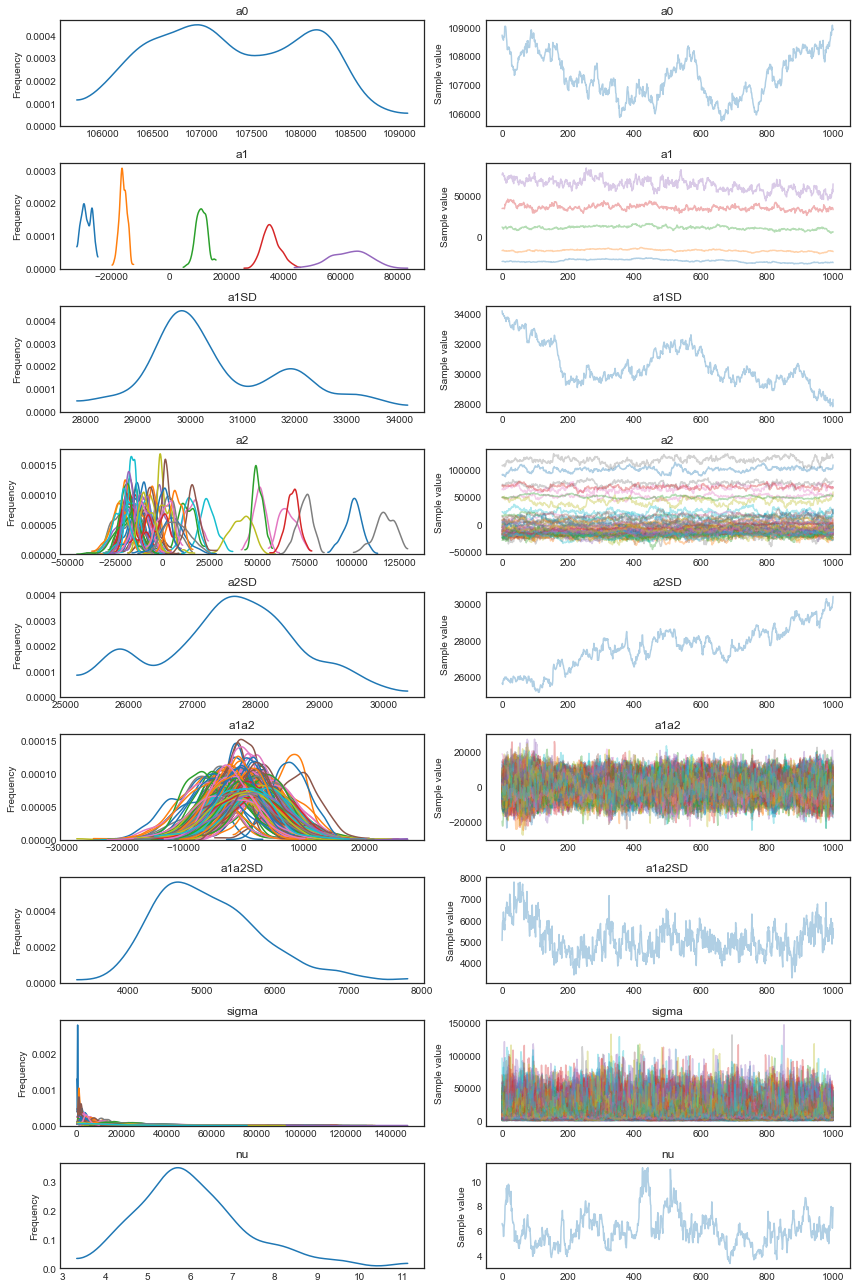

In [22]:
pm.traceplot(trace2, varnames=['a0', 'a1', 'a1SD', 'a2', 'a2SD', 'a1a2', 'a1a2SD', 'sigma', 'nu']);

In [23]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, len(trace2)))
b1b2 = m.copy()
sigma = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace2['a0'] +
                     trace2['a1'][:,j1] +
                     trace2['a2'][:,j2] +
                     trace2['a1a2'][:,j1,j2])
        sigma[j1,j2] = trace2['ySigma'][:,j1,j2]

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

print('b0: {}'.format(np.round(np.mean(b0))))
print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
print('b2: {}'.format(np.round(np.mean(b2, axis=1), decimals=3)[[20,48,12,7]]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[0,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[2,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[0,12]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[2,12]))

b0: 122968.0
b1: [-41736. -29269.  -1864.  22626.  50243.]
b2: [ -15403.08    -2064.643   10327.325  115091.975]
b1b2: 2444.448
b1b2: -3179.127
b1b2: -8653.669
b1b2: 4731.509


#### Figure 20.8

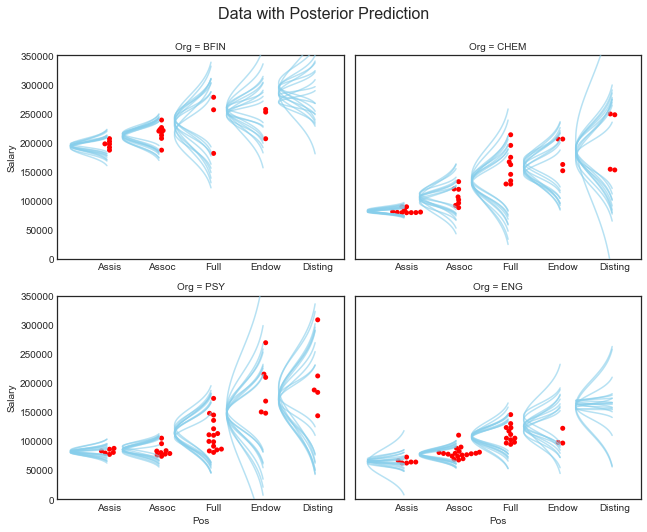

In [24]:
burnin = 20
scale = sigma

# Figure 20.8 in the book shows the Salary data for four of the sixty departments.
# Let's create the subset for plotting. 
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]

fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org,
                   col_wrap=2, size=3.5, aspect=1.3, despine=False, sharex=False) 
fg.map(sns.swarmplot, 'Pos', 'Salary', data=subset_df, color='r')
fg.fig.suptitle('Data with Posterior Prediction', y=1.05, fontsize=16)
for ax in fg.axes:
    ax.set_xlim(xmin=-1)
    ax.set_ylim((0,350000))
    
for i, org_idx in enumerate([7,12,48,20]):
    for pos_idx in np.arange(5):
        plot_mustache(b0[burnin:]+
                      b1[pos_idx, burnin:]+
                      b2[org_idx, burnin:]+
                      b1b2[pos_idx,org_idx,burnin:], sigma[pos_idx, org_idx, burnin:], pos_idx, ax=fg.axes.flatten()[i])

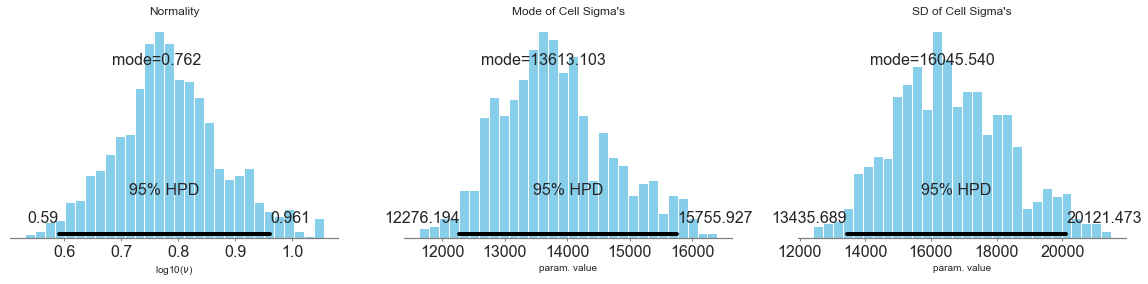

In [25]:
data = [np.log10(trace2['nu']),
        trace2['sigmaMode'],
        trace2['sigmaSD']]
            
titles = ['Normality',
          'Mode of Cell Sigma\'s',
          'SD of Cell Sigma\'s']        

xlabels = [r'log10($\nu$)'] + ['param. value']*2

fig, axes = plt.subplots(1,3, figsize=(20,4))

for d, t, l, ax in zip(data, titles, xlabels, axes):
    pm.plot_posterior(d, point_estimate='mode', color=color, ax=ax)
    ax.set_title(t)
    ax.set_xlabel(l)

#### Figure 20.9
For the interaction contrast we can use `ic_factors` defined above.

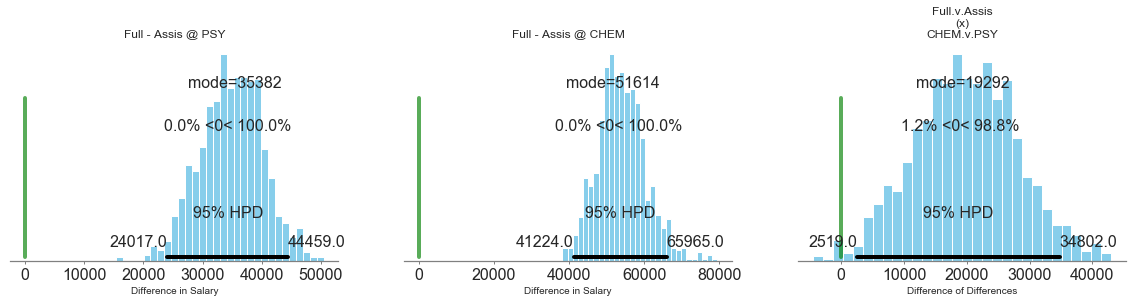

In [26]:
contrasts = [m[(df.Pos.cat.categories == 'Full').argmax(),
               (df.Org.cat.categories == 'PSY').argmax(),:] - 
             m[(df.Pos.cat.categories == 'Assis').argmax(),
               (df.Org.cat.categories == 'PSY').argmax(),:],
             
             m[(df.Pos.cat.categories == 'Full').argmax(),
               (df.Org.cat.categories == 'CHEM').argmax(),:] - 
             m[(df.Pos.cat.categories == 'Assis').argmax(),
               (df.Org.cat.categories == 'CHEM').argmax(),:],
             np.tensordot(ic_factors, b1b2)]

titles = ['Full - Assis @ PSY',
          'Full - Assis @ CHEM',
          'Full.v.Assis\n(x)\nCHEM.v.PSY']

xlabels = ['Difference in Salary']*2 + ['Difference of Differences']

fig, axes = plt.subplots(1,3, figsize=(20,4))

for c, t, l, ax in zip(contrasts, titles, xlabels, axes):
    pm.plot_posterior(c, point_estimate='mode', round_to=0, ref_val=0, color=color, ax=ax)
    ax.set_title(t)
    ax.set_xlabel(l)

### 20.5.2 - Split-plot design

In [9]:
df2 = pd.read_csv('data/SplitPlotAgriData.csv')
df2.Field = df2.Field.astype('category')
df2.Till = df2.Till.astype('category')
df2.Fert = df2.Fert.astype('category')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Field   99 non-null     category
 1   Till    99 non-null     category
 2   Fert    99 non-null     category
 3   Yield   99 non-null     int64   
dtypes: category(3), int64(1)
memory usage: 2.8 KB


In [10]:
df2.head()

,Field,Till,Fert,Yield
0,1,Chisel,Broad,119
1,1,Chisel,Deep,130
2,1,Chisel,Surface,123
3,2,Chisel,Broad,135
4,2,Chisel,Deep,148


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


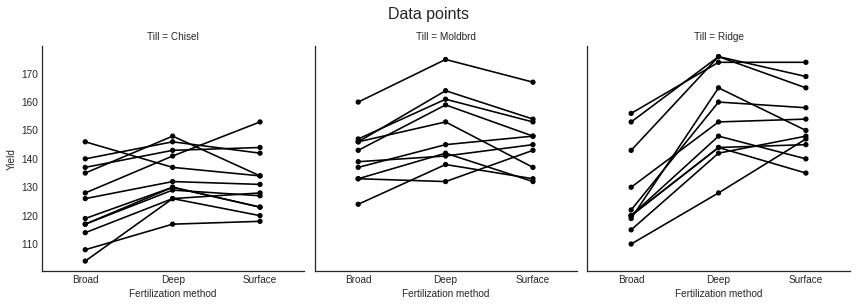

In [11]:
g = sns.FacetGrid(df2, col='Till', hue='Field', size=4)
g.map(sns.pointplot, 'Fert', 'Yield', color='k', scale=0.6)

for ax in g.axes.flatten():
    ax.set_xlabel('Fertilization method')
    
g.fig.suptitle('Data points', y=1.05, fontsize=16);

#### Model

In [12]:
# Tilling method
xBetween = df2.Till.cat.codes.values
xBetweenLvl = df2.Till.cat.categories
NxBetweenLvl = len(xBetweenLvl)

# Fertilization method
xWithin = df2.Fert.cat.codes.values
xWithinLvl = df2.Fert.cat.categories
NxWithinLvl = len(xWithinLvl)

# Individual fields
xSubject = df2.Field.cat.codes.values
xSubjectLvl = df2.Field.cat.categories
NxSubjectLvl = len(xSubjectLvl)

# Yield
y = df2.Yield
yMean = y.mean()
ySD = y.std()

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model3:
    
    # Baseline Yield
    #a0 = pm.Normal('a0', mu=yMean, tau=1/(ySD*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0.0, sd=1)
    a0 = pm.Deterministic('a0', 0.0 +ySD*5*a0_tilde)
    
    # Yield deflection from baseline for tilling method
    sigmaB = pm.Gamma('sigmaB', agammaShRa[0], agammaShRa[1])
    #aB = pm.Normal('aB', mu=0.0, tau=1/sigmaB**2, shape=NxBetweenLvl)
    aB_tilde = pm.Normal('aB_tilde', mu=0.0, sd=1, shape=NxBetweenLvl)
    aB = pm.Deterministic('aB', 0.0 + sigmaB*aB_tilde)
    
    # Yield deflection from baseline for fertilization method
    sigmaW = pm.Gamma('sigmaW', agammaShRa[0], agammaShRa[1])
    #aW = pm.Normal('aW', mu=0.0, tau=1/sigmaW**2, shape=NxWithinLvl)
    aW_tilde = pm.Normal('aW_tilde', mu=0.0, sd=1, shape=NxWithinLvl)
    aW = pm.Deterministic('aW', 0.0 + sigmaW*aW_tilde)
    
    # Yield deflection from baseline for combination of tilling and fertilization method
    sigmaBxW = pm.Gamma('sigmaBxW', agammaShRa[0], agammaShRa[1])
    #aBxW = pm.Normal('aBxW', mu=0.0, tau=1/sigmaBxW**2, shape=(NxBetweenLvl, NxWithinLvl))
    aBxW_tilde = pm.Normal('aBxW_tilde', mu=0.0, sd=1, shape=(NxBetweenLvl, NxWithinLvl))
    aBxW = pm.Deterministic('aBxW', 0.0 + sigmaBxW*aBxW_tilde)
    
    # Yield deflection from baseline for individual fields
    sigmaS = pm.Gamma('sigmaS', agammaShRa[0], agammaShRa[1])
    #aS = pm.Normal('aS', mu=0.0, tau=1/sigmaS**2, shape=NxSubjectLvl)
    aS_tilde = pm.Normal('aS_tilde', mu=0.0, sd=1, shape=NxSubjectLvl)
    aS = pm.Deterministic('aS', 0.0 + sigmaS*aS_tilde)
        
    mu = a0 + aB[xBetween] + aW[xWithin] + aBxW[xBetween, xWithin] + aS[xSubject] 
    sigma = pm.Uniform('sigma', ySD/100, ySD*10)
    
    like = pm.Normal('like', mu=mu, tau=1/sigma**2, observed=y)

In [16]:
with model3:
    trace3 = pm.sample(2000, target_accept=.98, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, aS_tilde, sigmaS, aBxW_tilde, sigmaBxW, aW_tilde, sigmaW, aB_tilde, sigmaB, a0_tilde]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 177 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


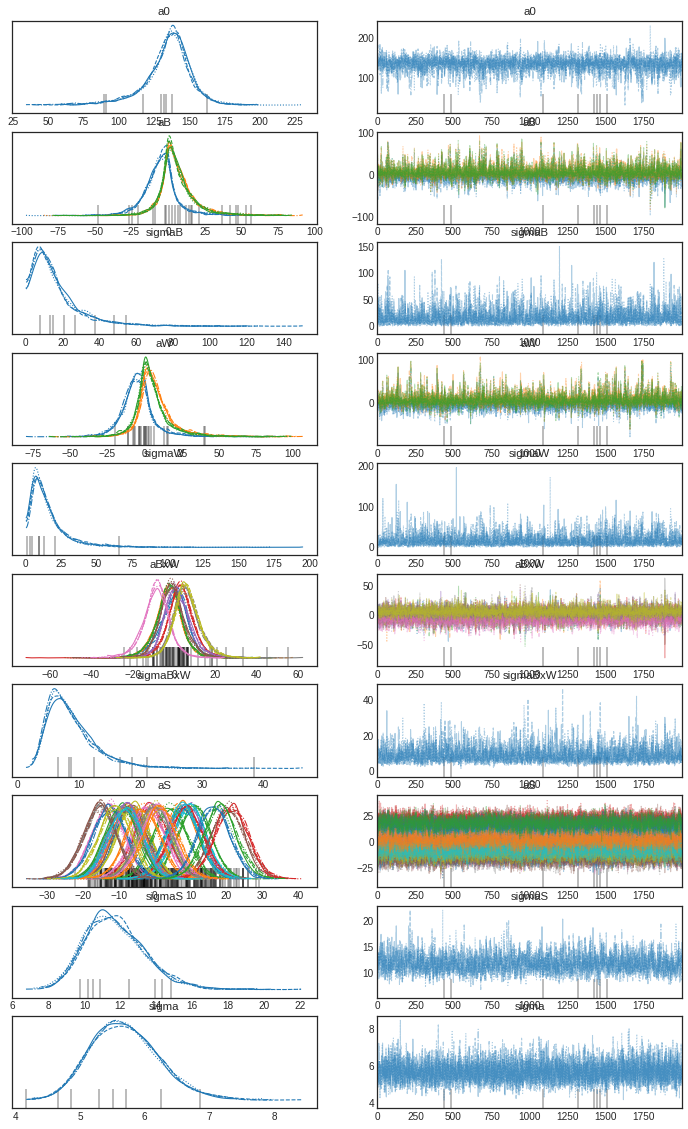

In [21]:
az.plot_trace(trace3, var_names=['a0', 'aB', 'sigmaB', 'aW', 'sigmaW', 'aBxW', 'sigmaBxW', 'aS', 'sigmaS', 'sigma']);

In [26]:
# stack all chains
traceSt = trace3.posterior.stack(draws=('chain','draw'))
traceSt['a0'].values.shape

(8000,)

In [27]:
a0 = traceSt['a0'].values
aB = traceSt['aB'].values
aW = traceSt['aW'].values
aBxW = traceSt['aBxW'].values
aS = traceSt['aS'].values
sigma = traceSt['sigma'].values

In [40]:
a0.shape[0]

8000

### Marginal means and sum-to-zero deflections

In contrast to the JAGS code from the book, we recenter the deflections after sampling. That is why there is an extra dimension containing all trace values.  

Let's put all the cell values in a multi-dimensional array.
- Axis 0: SubjectLvl S (Field)
- Axis 1: BetweenLvl B (Tilling method)
- Axis 2: WithinLvl W (Fertilization method)
- Axis 3: The corresponding mu values for the entire trace

We can use Numpy masked arrays, with the values '0' being masked. This helps with calculating means along the different axes: masked values (= empty cells) are not taken into account. This is important since there are different number of Fields for each Tilling method.

In [35]:
aBxW.shape

(3, 3, 8000)

In [41]:
# Initialize the array with zeros
mSxBxW = np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl, a0.shape[0]))
mSxBxW.shape

(33, 3, 3, 8000)

In [42]:
# Fill the arrray
for k, i, j in zip(xSubject, xBetween, xWithin):
    mu = a0 + aB[i,:] + aW[j,:] + aBxW[i,j,:] + aS[k,:]
    mSxBxW[k,i,j,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
mSxBxW_ma.shape

(33, 3, 3, 8000)

#### Calculating the means

In [43]:
# Mean for subject S across levels of W, within the level of B
mS = ma.mean(mSxBxW_ma, axis=(2))
mS.data.shape

(33, 3, 8000)

In [44]:
# Mean for treatment combination BxW, across subjects S
mBxW = mSxBxW_ma.mean(axis=(0))
mBxW.data.shape

(3, 3, 8000)

In [45]:
# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
mB.data.shape

(3, 1, 8000)

In [46]:
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
mW.shape

(1, 3, 8000)

#### Converting to sum-to-zero

In [47]:
# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
print('Mean baseline yield: {}'.format(b0.mean()))

Mean baseline yield: 140.4176014405291


In [48]:
# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m
print('Mean yield deflection from baseline for tilling method:')
pd.DataFrame(bB.data.mean(1), index=xBetweenLvl, columns=['Deflection'])

Mean yield deflection from baseline for tilling method:


,Deflection
Chisel,-10.549554
Moldbrd,5.468666
Ridge,5.080887


In [49]:
# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m
print('Mean yield deflection from baseline for fertilization method:')
pd.DataFrame(bW.data.mean(1), index=xWithinLvl, columns=['Deflection'])

Mean yield deflection from baseline for fertilization method:


,Deflection
Broad,-9.332082
Deep,6.248816
Surface,3.083266


In [50]:
# Equation 20.6
bBxW = mBxW - mB - mW + m
print('Mean yield deflection from baseline for tilling-fertilization combination:')
pd.DataFrame(bBxW.data.mean(2), index=xBetweenLvl, columns=xWithinLvl)

Mean yield deflection from baseline for tilling-fertilization combination:


,Broad,Deep,Surface
Chisel,3.660049,-2.236983,-1.423066
Moldbrd,4.009044,-1.157299,-2.851745
Ridge,-7.669094,3.394282,4.274812


In [51]:
# Equation 20.7
bS = mS - mB.squeeze()
print('Mean yield deflection from baseline for individual fields:')
pd.DataFrame(bS.mean(2).compressed(), index=xSubjectLvl, columns=['Deflection'])

Mean yield deflection from baseline for individual fields:


,Deflection
1,-5.379410
2,8.465595
3,11.881619
4,-0.145820
5,9.992248
6,-5.942669
7,-12.100873
8,-14.228930
9,-5.057963
10,10.636479


#### Figure 20.10

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


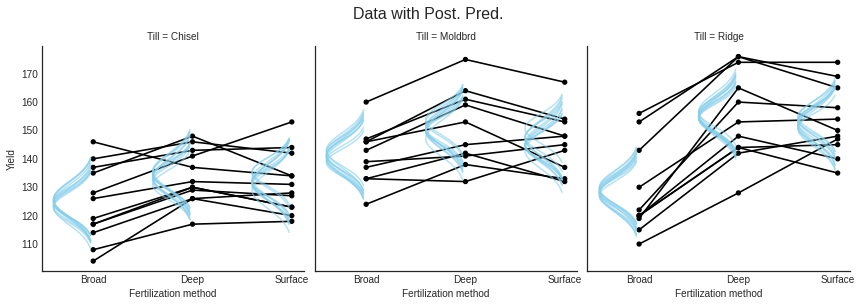

In [52]:
g = sns.FacetGrid(df2, col='Till', hue='Field', size=4)
g.map(sns.pointplot, 'Fert', 'Yield', color='k', scale=0.6)

# Above we found the mean values for the different deflections. Here we plot the
# full posteriors of the yield given tilling and fertilization method.
for i, j in np.ndindex(NxBetweenLvl, NxWithinLvl):
    plot_mustache(b0+
                  bB[i,:]+
                  bW[j,:]+
                  bBxW[i,j,:],
                  sigma,
                  j, width= 0.4, ax=g.axes.flatten()[i])

for ax in g.axes.flatten():
    ax.set_xlabel('Fertilization method')
    
g.fig.suptitle('Data with Post. Pred.', y=1.05, fontsize=16);

### Contrasts
#### Figure 20.11

In [53]:
# [Chisel & Moldbrd] vs [Ridge]
B = np.asarray([-.5, -.5, 1])
# [Broad] vs [Deep & Surface]
W = np.asarray([-1, .5, .5])
ic_factors = np.outer(B,W)
pd.DataFrame(ic_factors, index=xBetweenLvl, columns=xWithinLvl)

,Broad,Deep,Surface
Chisel,0.5,-0.25,-0.25
Moldbrd,0.5,-0.25,-0.25
Ridge,-1.0,0.50,0.50


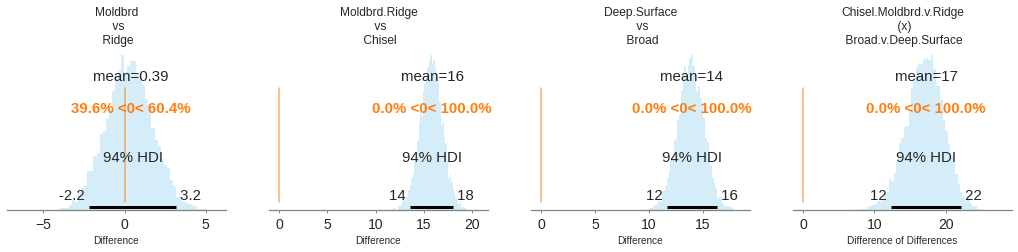

In [55]:
contrasts = [bB[1,:]-bB[2,:],
             ma.mean(bB[1:,:], axis=0) - bB[0,:],
             ma.mean(bW[1:,:], axis=0) - bW[0,:],
             np.tensordot(ic_factors, bBxW)]

titles = ['Moldbrd\n vs\n Ridge',
          'Moldbrd.Ridge\n vs\n Chisel',
          'Deep.Surface\n vs\n Broad',
          'Chisel.Moldbrd.v.Ridge\n (x)\n Broad.v.Deep.Surface']

xlabels = ['Difference']*3 + ['Difference of Differences']

fig, axes = plt.subplots(1,4, figsize=(18,3))

for c, t, l, ax in zip(contrasts, titles, xlabels, axes):
    az.plot_posterior(c, point_estimate='mean', ref_val=0, color=color, ax=ax, kind='hist')
    ax.set_title(t)
    ax.set_xlabel(l)

# Another example
- Taken from: Kruschke, J. K., & Liddell, T. M. (2018). The Bayesian New Statistics: Hypothesis testing, estimation, meta-analysis, and power analysis from a Bayesian perspective. Psychonomic Bulletin & Review, 25(1), 178–206.

In [57]:
df3 = pd.read_csv('data/RCT-DataGen-Data.csv')
df3

,Subj,Treatment,Time,Anxiety
0,1,Control,PreTreat,79
1,1,Control,PostTreat,68
2,1,Control,FollowUp1,91
3,1,Control,FollowUp2,71
4,2,Control,PreTreat,88
...,...,...,...,...
315,79,Counseling,FollowUp2,67
316,80,Counseling,PreTreat,84
317,80,Counseling,PostTreat,46
318,80,Counseling,FollowUp1,32


In [59]:
df3.Treatment = df3.Treatment.astype('category')
df3.Time = df3.Time.astype('category')
df3.Subj = df3.Subj.astype('category')
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Subj       320 non-null    category
 1   Treatment  320 non-null    category
 2   Time       320 non-null    category
 3   Anxiety    320 non-null    int64   
dtypes: category(3), int64(1)
memory usage: 6.6 KB


In [135]:
# change order of categories
df3.Time = pd.Categorical(df3.Time, 
                    categories=['PreTreat','PostTreat','FollowUp1', 'FollowUp2'])

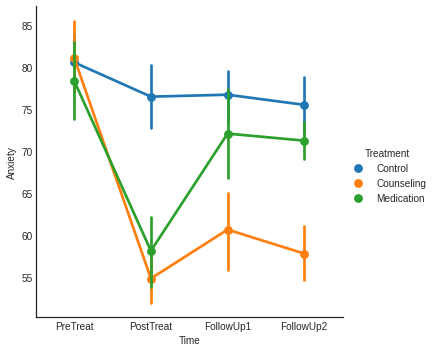

In [64]:
sns.catplot(x='Time', y='Anxiety', hue='Treatment', data=df3, kind='point')


In [65]:
# build similar model
# Treatment
xBetween = df3.Treatment.cat.codes.values
xBetweenLvl = df3.Treatment.cat.categories
NxBetweenLvl = len(xBetweenLvl)

# Time
xWithin = df3.Time.cat.codes.values
xWithinLvl = df3.Time.cat.categories
NxWithinLvl = len(xWithinLvl)

# Individual fields
xSubject = df3.Subj.cat.codes.values
xSubjectLvl = df3.Subj.cat.categories
NxSubjectLvl = len(xSubjectLvl)

# Anxiety
y = df3.Anxiety
yMean = y.mean()
ySD = y.std()

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model4:
    
    # Baseline Anxiety
    a0_tilde = pm.Normal('a0_tilde', mu=0.0, sd=1)
    a0 = pm.Deterministic('a0', 0.0 +ySD*5*a0_tilde)
    
    # Anxiety deflection from baseline for treatment method
    sigmaB = pm.Gamma('sigmaB', agammaShRa[0], agammaShRa[1])
    #aB = pm.Normal('aB', mu=0.0, tau=1/sigmaB**2, shape=NxBetweenLvl)
    aB_tilde = pm.Normal('aB_tilde', mu=0.0, sd=1, shape=NxBetweenLvl)
    aB = pm.Deterministic('aB', 0.0 + sigmaB*aB_tilde)
    
    # Anxiety deflection from baseline for time method
    sigmaW = pm.Gamma('sigmaW', agammaShRa[0], agammaShRa[1])
    #aW = pm.Normal('aW', mu=0.0, tau=1/sigmaW**2, shape=NxWithinLvl)
    aW_tilde = pm.Normal('aW_tilde', mu=0.0, sd=1, shape=NxWithinLvl)
    aW = pm.Deterministic('aW', 0.0 + sigmaW*aW_tilde)
    
    # Anxiety deflection from baseline for combination of treatment and time method
    sigmaBxW = pm.Gamma('sigmaBxW', agammaShRa[0], agammaShRa[1])
    #aBxW = pm.Normal('aBxW', mu=0.0, tau=1/sigmaBxW**2, shape=(NxBetweenLvl, NxWithinLvl))
    aBxW_tilde = pm.Normal('aBxW_tilde', mu=0.0, sd=1, shape=(NxBetweenLvl, NxWithinLvl))
    aBxW = pm.Deterministic('aBxW', 0.0 + sigmaBxW*aBxW_tilde)
    
    # Anxiety deflection from baseline for individual fields
    sigmaS = pm.Gamma('sigmaS', agammaShRa[0], agammaShRa[1])
    #aS = pm.Normal('aS', mu=0.0, tau=1/sigmaS**2, shape=NxSubjectLvl)
    aS_tilde = pm.Normal('aS_tilde', mu=0.0, sd=1, shape=NxSubjectLvl)
    aS = pm.Deterministic('aS', 0.0 + sigmaS*aS_tilde)
        
    mu = a0 + aB[xBetween] + aW[xWithin] + aBxW[xBetween, xWithin] + aS[xSubject] 
    sigma = pm.Uniform('sigma', ySD/100, ySD*10)
    
    like = pm.Normal('like', mu=mu, tau=1/sigma**2, observed=y)
    
    trace4 = pm.sample(2000, target_accept=.98, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, aS_tilde, sigmaS, aBxW_tilde, sigmaBxW, aW_tilde, sigmaW, aB_tilde, sigmaB, a0_tilde]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 156 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [66]:
# stack all chains
traceSt = trace4.posterior.stack(draws=('chain','draw'))
traceSt['a0'].values.shape

(8000,)

In [67]:
a0 = traceSt['a0'].values
aB = traceSt['aB'].values
aW = traceSt['aW'].values
aBxW = traceSt['aBxW'].values
aS = traceSt['aS'].values
sigma = traceSt['sigma'].values

In [68]:
# Initialize the array with zeros
mSxBxW = np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl, a0.shape[0]))
mSxBxW.shape

(80, 3, 4, 8000)

In [134]:
# Fill the arrray
for k, i, j in zip(xSubject, xBetween, xWithin):
    mu = a0 + aB[i,:] + aW[j,:] + aBxW[i,j,:] + aS[k,:]
    mSxBxW[k,i,j,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
mSxBxW_ma.shape

(80, 3, 4, 8000)

#### Calculating the means

In [108]:
# Mean for subject S across levels of W, within the level of B
mS = ma.mean(mSxBxW_ma, axis=(2))
mS.data.shape

(80, 3, 8000)

In [109]:
# Mean for treatment combination BxW, across subjects S
mBxW = mSxBxW_ma.mean(axis=(0))
mBxW.data.shape

(3, 4, 8000)

In [114]:
# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
mB.data.shape

(3, 1, 8000)

In [115]:
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
mW.shape

(1, 4, 8000)

#### Converting to sum-to-zero

In [116]:
# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
print('Mean baseline anxiety: {}'.format(b0.mean()))

Mean baseline anxiety: 70.28717986810199


In [117]:
# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m
print('Mean anxiety deflection from baseline for treatment:')
pd.DataFrame(bB.data.mean(1), index=xBetweenLvl, columns=['Deflection'])

Mean anxiety deflection from baseline for treatment:


,Deflection
Control,6.922808
Counseling,-6.585049
Medication,-0.337758


In [118]:
# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m
print('Mean anxiety deflection from baseline for time:')
pd.DataFrame(bW.data.mean(1), index=xWithinLvl, columns=['Deflection'])

Mean anxiety deflection from baseline for time:


,Deflection
PreTreat,9.508021
PostTreat,-6.970832
FollowUp1,-0.460363
FollowUp2,-2.076826


In [120]:
# Equation 20.6
bBxW = mBxW - mB - mW + m
print('Mean anxiety deflection from baseline for treatment-time combination:')
pd.DataFrame(bBxW.data.mean(2), index=xBetweenLvl, columns=xWithinLvl)

Mean anxiety deflection from baseline for treatment-time combination:


,PreTreat,PostTreat,FollowUp1,FollowUp2
Control,-5.970536,5.831324,-0.118079,0.257291
Counseling,7.184284,-1.532358,-2.250887,-3.401039
Medication,-1.213748,-4.298966,2.368966,3.143748


In [121]:
# Equation 20.7
bS = mS - mB.squeeze()
print('Mean anxiety deflection from baseline for individuals:')
pd.DataFrame(bS.mean(2).compressed(), index=xSubjectLvl, columns=['Deflection'])

Mean anxiety deflection from baseline for individuals:


,Deflection
1,-0.050408
2,-0.154463
3,-0.921121
4,-0.370444
5,4.856074
...,...
76,-0.507640
77,-4.780196
78,1.968408
79,1.964027


#### Figure 20.10

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


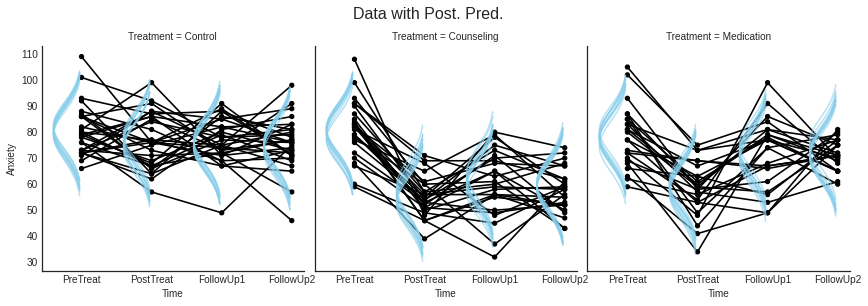

In [123]:
g = sns.FacetGrid(df3, col='Treatment', hue='Subj', height=4)
g.map(sns.pointplot, 'Time', 'Anxiety', color='k', scale=0.6)

# Above we found the mean values for the different deflections. Here we plot the
# full posteriors of the yield given tilling and fertilization method.
for i, j in np.ndindex(NxBetweenLvl, NxWithinLvl):
    plot_mustache(b0+
                  bB[i,:]+
                  bW[j,:]+
                  bBxW[i,j,:],
                  sigma,
                  j, width= 0.4, ax=g.axes.flatten()[i])

for ax in g.axes.flatten():
    ax.set_xlabel('Time')
    
g.fig.suptitle('Data with Post. Pred.', y=1.05, fontsize=16);

### Contrasts
#### Figure 20.11

In [126]:
# [Medication & Conseling] vs [Control]
B = np.asarray([1, 0, -1])
# [post treatment] vs [Followup1 & Followup2]
W = np.asarray([-1,1, 0, 0])
ic_factors = np.outer(B,W)
pd.DataFrame(ic_factors, index=xBetweenLvl, columns=xWithinLvl)

,PreTreat,PostTreat,FollowUp1,FollowUp2
Control,-1,1,0,0
Counseling,0,0,0,0
Medication,1,-1,0,0


In [127]:
# another contrast
#  conseling vs. medication in postTrt vs. F1.F2
B = np.asarray([0, 1, -1])
# [post treatment] vs [Followup1 & Followup2]
W = np.asarray([0,1, -.5, -.5])
ic_factors2 = np.outer(B,W)
pd.DataFrame(ic_factors2, index=xBetweenLvl, columns=xWithinLvl)

,PreTreat,PostTreat,FollowUp1,FollowUp2
Control,0.0,0.0,-0.0,-0.0
Counseling,0.0,1.0,-0.5,-0.5
Medication,-0.0,-1.0,0.5,0.5


In [104]:
np.tensordot(ic_factors, bBxW)

array([5.50073821, 4.10953734, 0.37987132, ..., 6.326935  , 3.30794713,
       0.5163892 ])

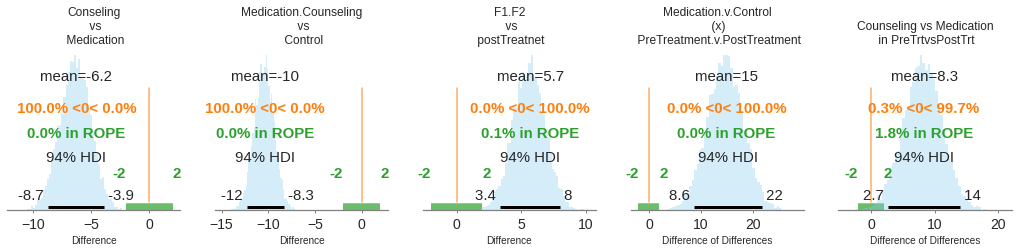

In [132]:
contrasts = [bB[1,:]-bB[2,:],
             ma.mean(bB[1:,:], axis=0) - bB[0,:],
             ma.mean(bW[2:,:], axis=0) - bW[1,:],
             np.tensordot(ic_factors, bBxW),
            np.tensordot(ic_factors2, bBxW)]

titles = ['Conseling\n vs\n Medication',
          'Medication.Counseling\n vs\n Control',
          'F1.F2\n vs\n postTreatnet',
          'Medication.v.Control\n (x)\n PreTreatment.v.PostTreatment',
         'Counseling vs Medication\n in PreTrtvsPostTrt']

xlabels = ['Difference']*3 + ['Difference of Differences']*2

fig, axes = plt.subplots(1,5, figsize=(18,3))

for c, t, l, ax in zip(contrasts, titles, xlabels, axes):
    az.plot_posterior(c, point_estimate='mean', ref_val=0, color=color, ax=ax, kind='hist', rope=[-2,2])
    ax.set_title(t)
    ax.set_xlabel(l)

In [137]:
8.7-3.9

4.799999999999999